In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np  
import math 
import datetime
from keras import applications  
import keras
from sklearn import metrics
from tensorflow.keras import optimizers
from keras.optimizers import rmsprop_v2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense 
from keras.utils.np_utils import to_categorical 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
from keras.callbacks import EarlyStopping

In [2]:
import pandas as pd
import os

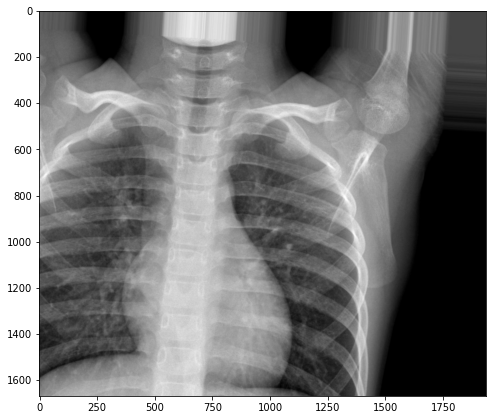

In [3]:
plt.figure(figsize= (8, 8))
img = mpimg.imread("../input/train/Normal/test_0_9774.jpeg")
plt.imshow(img)
plt.show()

In [4]:
train_path=os.path.join("../input/train")
val_path=os.path.join("../input/val")
test_path=os.path.join("../input/test")

batch_size = 16

In [5]:
start = datetime.datetime.now()
traingen = ImageDataGenerator(rescale= 1./255,
                             shear_range=0.2,
                             width_shift_range=0.2 , 
                             height_shift_range=0.2 ,
                             zoom_range=0.2,
                             horizontal_flip=True)
valgen = ImageDataGenerator(rescale= 1./255)
testgen = ImageDataGenerator(rescale= 1./255)

In [6]:
train_it=traingen.flow_from_directory(
      train_path,
      target_size=(224,224),
      class_mode='categorical',
      batch_size=batch_size
      )

val_it=traingen.flow_from_directory(
      val_path,
      target_size=(224,224),
      class_mode='categorical',
      batch_size=batch_size
    
      )

test_it=traingen.flow_from_directory(
      test_path,
      target_size=(224,224),
      shuffle=False,
      class_mode='categorical',
      batch_size=batch_size
      )

nb_train_samples = len(train_it.filenames) 
num_classes = len(train_it.class_indices) 


 
train_labels = train_it.classes 
test_labels= test_it.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

val_labels=val_it.classes
val_labels = to_categorical(val_labels, num_classes=num_classes)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


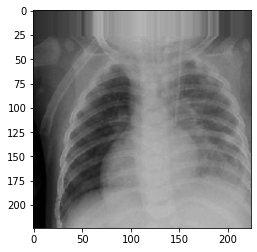

In [7]:
plt.figure()
plt.imshow(next(train_it)[0][0])
plt.show()

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_it.classes), y=train_it.classes)

class_weights = dict(zip( np.unique(train_it.classes), class_weights))
class_weights
print(class_weights)

{0: 1.0048132780082988, 1: 0.994088669950739, 2: 1.0031483015741507, 3: 0.9924590163934426, 4: 1.0056478405315614}


In [9]:
base_model_201 = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model_201.layers:
  layer.trainable = False

x = layers.Flatten()(base_model_201.output)
x = layers.Dropout(0.5)(x) 
x = layers.Dense(512, activation= 'relu')(x)
x = layers.Dense(5, activation = 'softmax')(x)

model2 = tf.keras.models.Model(base_model_201.input, x)

2022-06-19 16:21:03.204852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 16:21:03.313062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 16:21:03.314097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 16:21:03.315569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 0s 0us/step


In [10]:
model2.compile('adam', loss = 'categorical_crossentropy',metrics = ['acc'])

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [12]:

Checkpoint = tf.keras.callbacks.ModelCheckpoint("densenet201.hdf5", monitor="val_acc", save_best_only= True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor= "val_acc", factor= 0.5, patience= 4, verbose= 3,cooldown=2,  mode= "max", min=2, min_lr= 0.0000001)

In [13]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [14]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [15]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_it.classes),y=train_it.classes)
class_weights = dict(zip( np.unique(train_it.classes), class_weights))
class_weights 
print(class_weights)

{0: 1.0048132780082988, 1: 0.994088669950739, 2: 1.0031483015741507, 3: 0.9924590163934426, 4: 1.0056478405315614}


In [16]:
history=model2.fit(train_it, validation_data= val_it,class_weight=class_weights, epochs=100 , callbacks= [reduce_lr, early , Checkpoint])

2022-06-19 16:21:12.446817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-19 16:21:24.330599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


379/379 [==============================] - 321s 802ms/step - loss: 1.4572 - acc: 0.7365 - val_loss: 0.5739 - val_acc: 0.7773
Epoch 2/100
379/379 [==============================] - 222s 586ms/step - loss: 0.4801 - acc: 0.8031 - val_loss: 0.4268 - val_acc: 0.8323
Epoch 3/100
379/379 [==============================] - 219s 577ms/step - loss: 0.4195 - acc: 0.8259 - val_loss: 0.4371 - val_acc: 0.8229
Epoch 4/100
379/379 [==============================] - 224s 590ms/step - loss: 0.4074 - acc: 0.8246 - val_loss: 0.4115 - val_acc: 0.8299
Epoch 5/100
379/379 [==============================] - 220s 581ms/step - loss: 0.3933 - acc: 0.8393 - val_loss: 0.4513 - val_acc: 0.8090
Epoch 6/100
379/379 [==============================] - 219s 578ms/step - loss: 0.3687 - acc: 0.8408 - val_loss: 0.4151 - val_acc: 0.8309

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
379/379 [==============================] - 219s 577ms/step - loss: 0.3537 - acc: 0.8497 - val_los

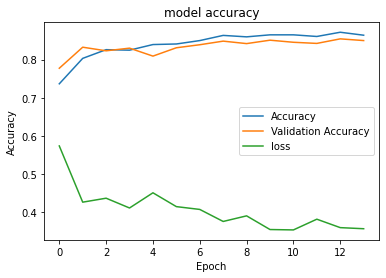

In [17]:
plt.plot(history.history["acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [18]:
preds = model2.predict(test_it,verbose=1).argmax(axis=1)

127/127 [==============================] - 79s 598ms/step


In [19]:
predictions = preds.copy()
threshold=0.5
predictions=np.where(predictions<threshold,0,1)

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [21]:
len(test_labels)

2025

In [22]:
test_labels_tentative = pd.DataFrame(test_labels).idxmax(axis=1)
preds_tentative = pd.DataFrame(preds).idxmax(axis=1)

In [23]:
len(test_labels_tentative), len(test_labels)

(2025, 2025)

In [24]:
confusion_matrix= confusion_matrix(test_labels_tentative, preds_tentative)

In [25]:
confusion_matrix

array([[2025]])

In [26]:
import itertools

<AxesSubplot:>

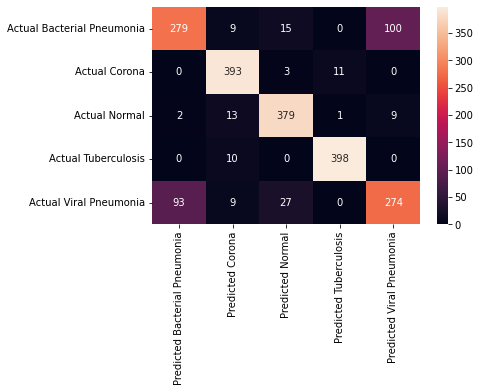

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_it.classes, preds, labels = [0,1,2,3,4]),
                  index=["Actual Bacterial Pneumonia","Actual Corona Virus","Actual Normal","Actual Tuberculosis", "Actual Viral Pneumonia"],
                  columns=["Predicted Bacterial Pneumonia","Predicted Corona Virus","Predicted Normal","Predicted Tuberculosis", "Predicted Viral Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")
 



In [28]:
classification_metrics = metrics.classification_report(test_labels, preds,
                                                      target_names =['BACTERIAL PNEUMONIA','CORONA','NORMAL','TUBERCULOSIS','VIRAL PNEUMONIA'])
print(classification_metrics)

                     precision    recall  f1-score   support

BACTERİAL PNEUMONIA       0.75      0.69      0.72       403
             CORONA       0.91      0.97      0.93       407
             NORMAL       0.89      0.94      0.92       404
       TUBERCULOSIS       0.97      0.98      0.97       408
    VIRAL PNEUMONIA       0.72      0.68      0.70       403

           accuracy                           0.85      2025
          macro avg       0.85      0.85      0.85      2025
       weighted avg       0.85      0.85      0.85      2025



In [29]:
def load_and_prep_image(filename, img_shape=224):
 
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  
    return img

In [30]:
import pathlib

In [31]:
data_dir = pathlib.Path("../input/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) 
print(class_names)

['Bacterial Pneumonia' 'Corona Virus Disease' 'Normal' 'Tuberculosis'
 'Viral Pneumonia']


In [32]:
def pred_and_plot(model, filename, class_names):
  
  
  img = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  
  if len(pred[0]) > 1: 
    pred_class = class_names[pred.argmax()] 
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

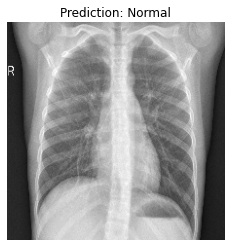

In [33]:
pred_and_plot(model=model2, 
              filename="../input/IM-0003-0001.jpeg",
              class_names =class_names)